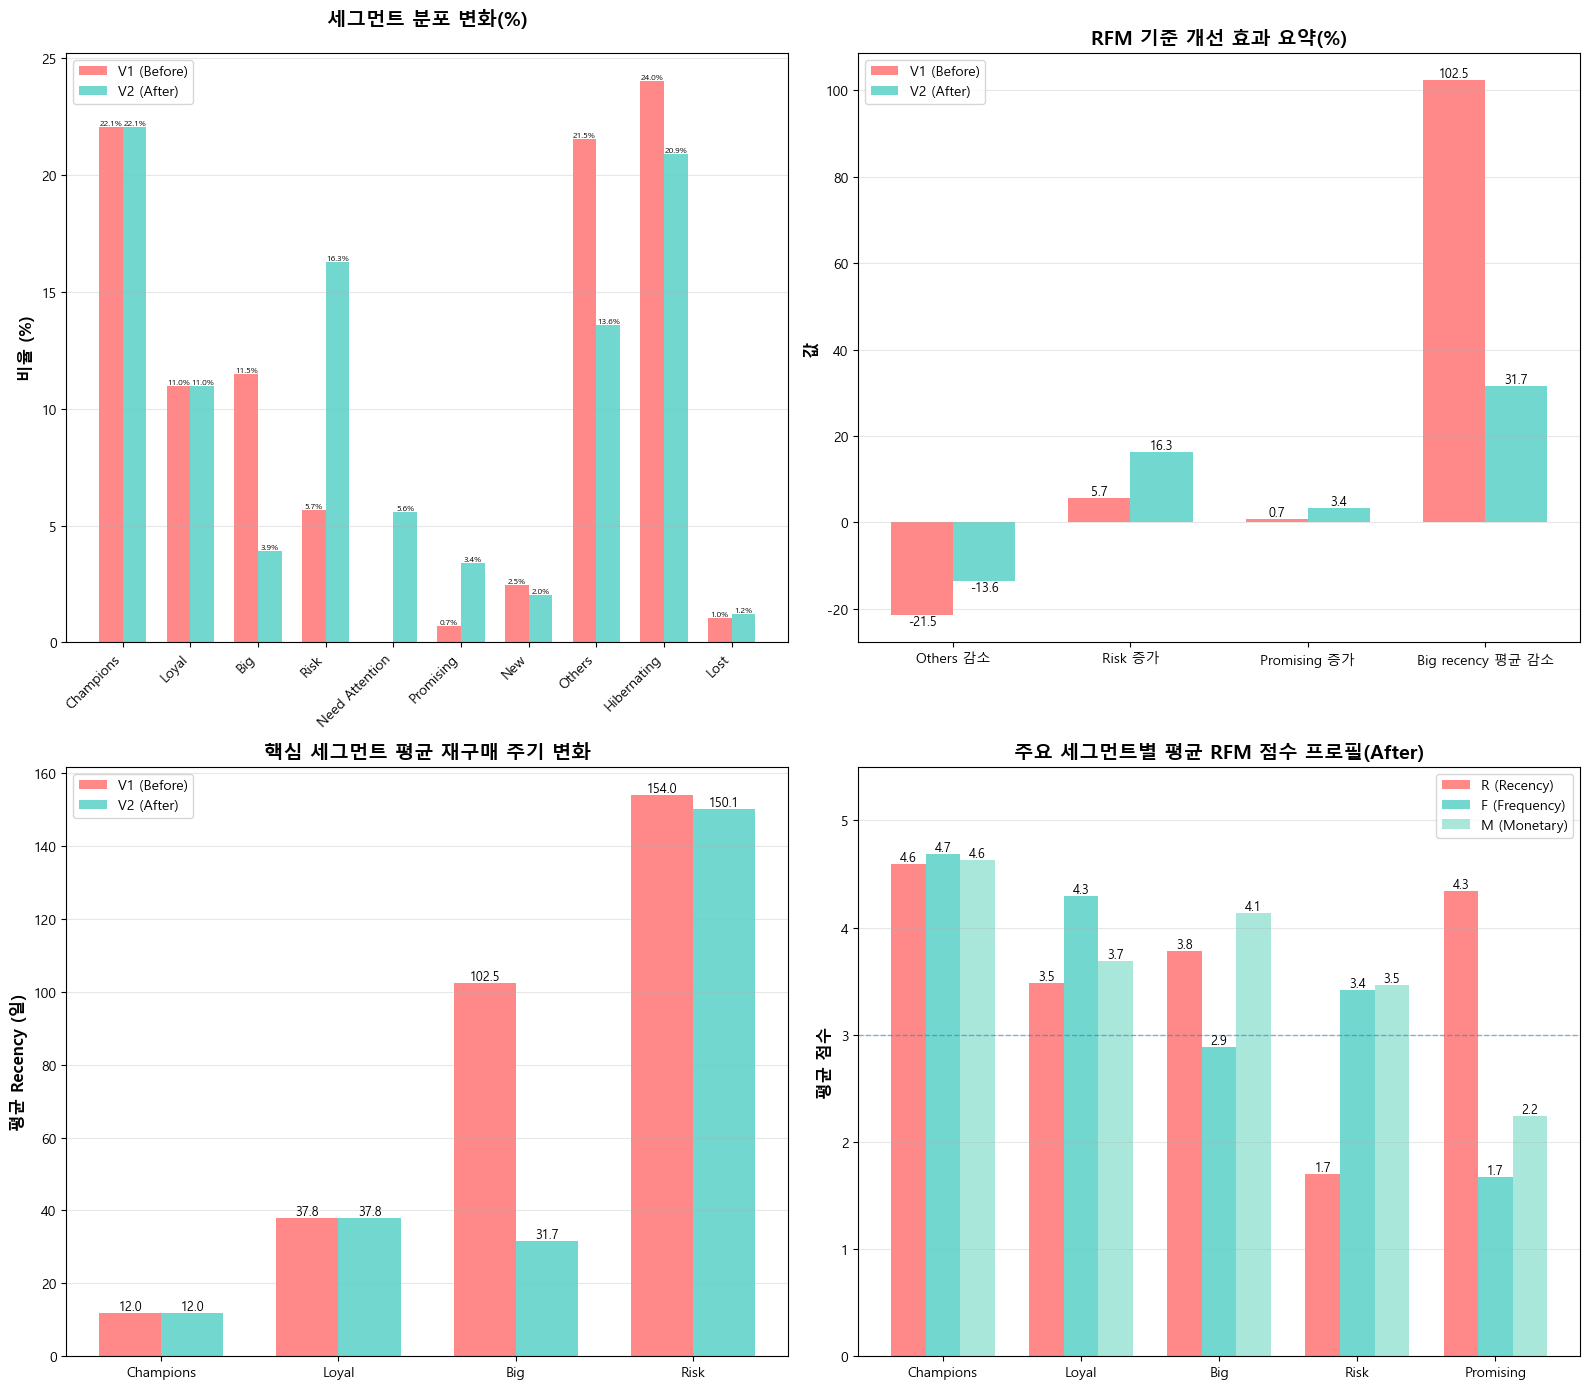

In [44]:
import pandas as pd
from sqlalchemy import create_engine
import os
from dotenv import load_dotenv
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 1. sql 연결 설정
# .env 파일 로드
load_dotenv()

# 환경변수에서 읽기
DB_USER = os.getenv('DB_USER')
DB_PASSWORD = os.getenv('DB_PASSWORD')
DB_HOST = os.getenv('DB_HOST')
DB_PORT = os.getenv('DB_PORT')
DB_NAME = os.getenv('DB_NAME')

# 연결 엔진 생성
engine = create_engine(f'postgresql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}')
# print(engine)


# 2. sql view 불러오기
df_v1 = pd.read_sql("SELECT * FROM rfm_summary_v1", engine)
df_v2 = pd.read_sql("SELECT * FROM rfm_summary_v2", engine)


# 3. 시각화 환경설정
# 한글 폰트 설정 (Windows)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 세그먼트 순서 정의 (중요도순)
segment_order = ['Champions', 'Loyal', 'Big', 'Risk', 'Need Attention', 
                 'Promising', 'New', 'Others', 'Hibernating', 'Lost']

# 전체 Figure 생성
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
width = 0.35

# 값 표시 함수 생성성
def add_value_labels(ax, fmt='{:.1f}', y_offset=0):
    for bar in ax.patches:
        height = bar.get_height()
        if height > 0:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height + y_offset,
                fmt.format(height),
                ha='center',
                va='bottom',
                fontsize=9)
        else:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height + y_offset,
                fmt.format(height),
                ha='center',
                va='top',
                fontsize=9)

# ============================================================================
# 1. 세그먼트 비율 비교 (%)
# ============================================================================
ax1 = plt.subplot(2, 2, 1)

v1_percentages = []
v2_percentages = []

for seg in segment_order:
    v1_percentages.append(
        df_v1.loc[df_v1['segment_name'] == seg, 'percentage'].values[0]
        if seg in df_v1['segment_name'].values else 0
    )
    v2_percentages.append(
        df_v2.loc[df_v2['segment_name'] == seg, 'percentage'].values[0]
        if seg in df_v2['segment_name'].values else 0
    )

x = np.arange(len(segment_order))

bars1 = ax1.bar(x - width/2, v1_percentages, width, label='V1 (Before)',color='#FF6B6B', alpha=0.8)
bars2 = ax1.bar(x + width/2, v2_percentages, width, label='V2 (After)',color='#4ECDC4', alpha=0.8)

ax1.set_title('세그먼트 분포 변화(%)', fontsize=14, fontweight='bold',pad=20)
ax1.set_ylabel('비율 (%)',fontsize=12, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(segment_order, rotation=45, ha='right')
ax1.legend(fontsize=10)
ax1.grid(axis='y', alpha=0.3)

# 값 표시
for bars in [bars1, bars2]:
    for bar in bars:
        if bar.get_height() > 0:
            ax1.text(bar.get_x() + bar.get_width()/2,
                     bar.get_height(),
                     f"{bar.get_height():.1f}%",
                     ha='center', va='bottom', fontsize=6)


# ============================================================================
# 2. 주요 개선 지표 하이라이트
# ============================================================================
ax2 = plt.subplot(2, 2, 2)

improvements = {
    'Others 감소': [-21.53, -13.58],
    'Risk 증가': [5.67, 16.3],
    'Promising 증가': [0.69, 3.41],
    'Big recency 평균 감소': [102.5, 31.7]
}

labels = list(improvements.keys())
v1_vals = [improvements[k][0] for k in labels]
v2_vals = [improvements[k][1] for k in labels]

x_imp = np.arange(len(labels))

ax2.bar(x_imp - width/2, v1_vals, width, label='V1 (Before)',color='#FF6B6B', alpha=0.8)
ax2.bar(x_imp + width/2, v2_vals, width, label='V2 (After)',color='#4ECDC4', alpha=0.8)

ax2.set_title('RFM 기준 개선 효과 요약(%)', fontsize=14, fontweight='bold')
ax2.set_ylabel('값', fontsize=12, fontweight='bold')
ax2.set_xticks(x_imp)
ax2.set_xticklabels(labels)
ax2.legend()
ax2.grid(axis='y', alpha=0.3)
add_value_labels(ax2, fmt='{:.1f}')


# ============================================================================
# 3. 핵심 세그먼트 평균 Recency 비교
# ============================================================================
ax3 = plt.subplot(2, 2, 3)

key_segments = ['Champions', 'Loyal', 'Big', 'Risk']
v1_recency = []
v2_recency = []

for seg in key_segments:
    v1_recency.append(
        df_v1.loc[df_v1['segment_name'] == seg, 'avg_recency'].values[0]
        if seg in df_v1['segment_name'].values else 0
    )
    v2_recency.append(
        df_v2.loc[df_v2['segment_name'] == seg, 'avg_recency'].values[0]
        if seg in df_v2['segment_name'].values else 0
    )

x_rec = np.arange(len(key_segments))

ax3.bar(x_rec - width/2, v1_recency, width, label='V1 (Before)',color='#FF6B6B', alpha=0.8)
ax3.bar(x_rec + width/2, v2_recency, width, label='V2 (After)',color='#4ECDC4', alpha=0.8)

ax3.set_title('핵심 세그먼트 평균 재구매 주기 변화', fontsize=14, fontweight='bold')
ax3.set_ylabel('평균 Recency (일)', fontsize=12, fontweight='bold')
ax3.set_xticks(x_rec)
ax3.set_xticklabels(key_segments)
ax3.legend()
ax3.grid(axis='y', alpha=0.3)
add_value_labels(ax3, fmt='{:.1f}')

# ============================================================================
# 4. 세그먼트별 RFM 점수 평균 (df_v1 / df_v2 기반)
# ============================================================================

ax4 = plt.subplot(2, 2, 4)

segments = ['Champions', 'Loyal', 'Big', 'Risk', 'Promising']
x_seg = np.arange(len(segments))
width = 0.25

def get_scores(df, col):
    return [
        df.loc[df['segment_name'] == seg, col].values[0]
        if seg in df['segment_name'].values else 0
        for seg in segments
    ]

# v2 기준 (개선 후 프로필 강조)
r_scores = get_scores(df_v2, 'avg_r_score')
f_scores = get_scores(df_v2, 'avg_f_score')
m_scores = get_scores(df_v2, 'avg_m_score')

ax4.bar(x_seg - width, r_scores, width, label='R (Recency)',color='#FF6B6B', alpha=0.8)
ax4.bar(x_seg, f_scores, width, label='F (Frequency)',color='#4ECDC4', alpha=0.8)
ax4.bar(x_seg + width, m_scores, width, label='M (Monetary)',color='#95E1D3', alpha=0.8)

ax4.set_title('주요 세그먼트별 평균 RFM 점수 프로필(After)', 
              fontsize=14, fontweight='bold')
ax4.set_ylabel('평균 점수',fontsize=12, fontweight='bold')
ax4.set_xticks(x_seg)
ax4.set_xticklabels(segments)
ax4.set_ylim(0, 5.5)
ax4.legend()
ax4.grid(axis='y', alpha=0.3)
ax4.axhline(y=3, linestyle='--', linewidth=1, alpha=0.5)
add_value_labels(ax4, fmt='{:.1f}')


plt.tight_layout()
plt.savefig('rfm_before_after_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


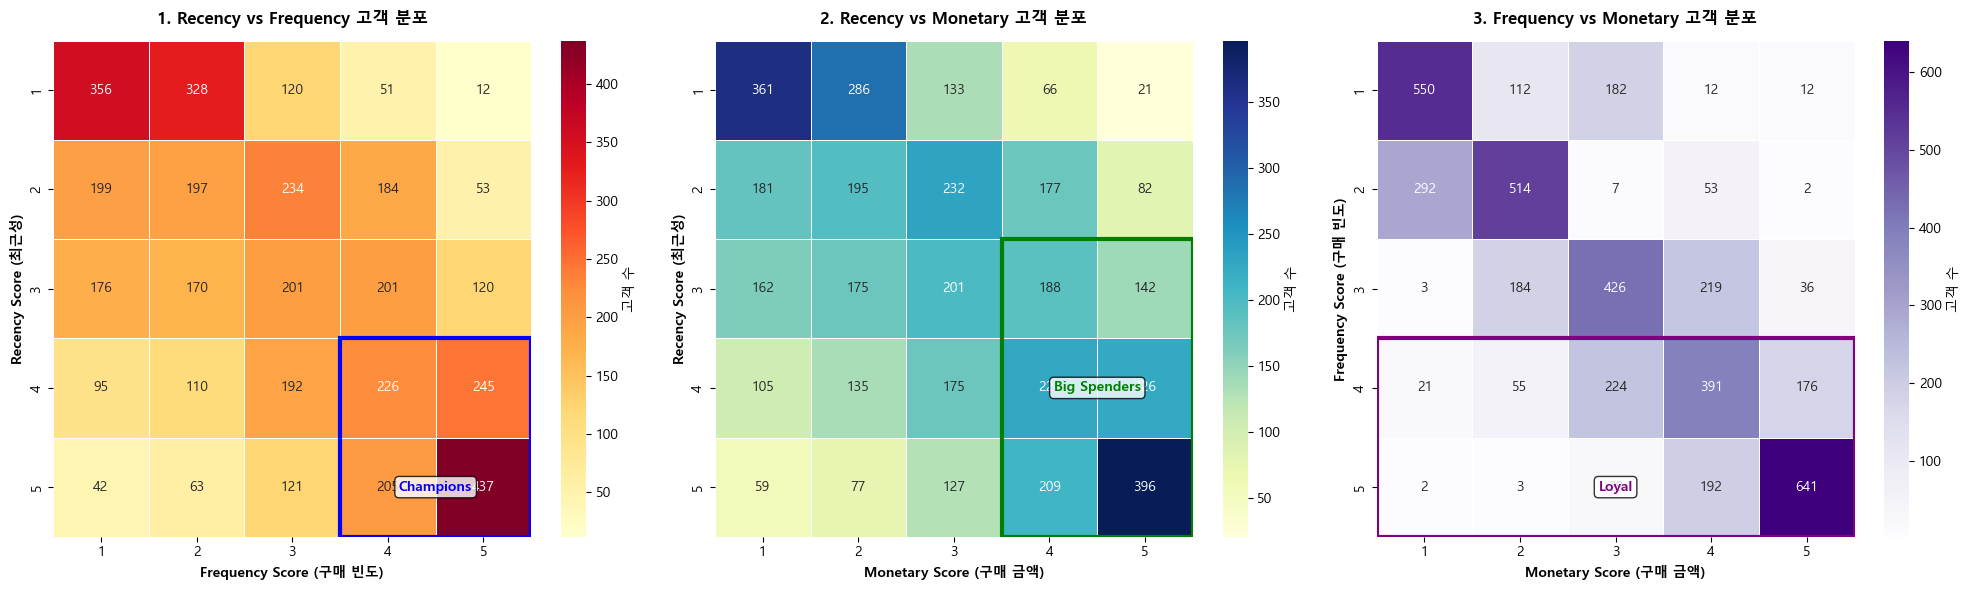

In [45]:
# 히트맵 시각화 (개선 버전 v2)
df_rfm = pd.read_sql("SELECT * FROM rfm_customer_segments_v2", engine)

# 히트맵용 매트릭스 생성
rf_matrix = (df_rfm.groupby(['r_score', 'f_score'])
          .size()
          .unstack(fill_value=0))
rm_matrix = (df_rfm.groupby(['r_score', 'm_score'])
          .size()
          .unstack(fill_value=0))
fm_matrix = (df_rfm.groupby(['f_score', 'm_score'])
          .size()
          .unstack(fill_value=0))

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# 1. R-F 히트맵
ax1 = axes[0]
sns.heatmap(
    rf_matrix,
    annot=True, fmt='d', cmap='YlOrRd',
    xticklabels=[1,2,3,4,5], yticklabels=[1,2,3,4,5],
    cbar_kws={'label': '고객 수'},
    linewidths=0.5, ax=ax1)

ax1.set_xlabel('Frequency Score (구매 빈도)', fontweight='bold')
ax1.set_ylabel('Recency Score (최근성)', fontweight='bold')
ax1.set_title('1. Recency vs Frequency 고객 분포', fontweight='bold', pad=12)

# "Champions" 영역
rect1 = plt.Rectangle((3, 3), 2, 2, fill=False, edgecolor='blue', linewidth=3)
ax1.add_patch(rect1)
ax1.text(
    4, 4.5, 'Champions',
    ha='center', va='center',
    fontweight='bold', color='blue',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 2. R-M 히트맵
ax2 = axes[1]
sns.heatmap(
    rm_matrix,
    annot=True, fmt='d', cmap='YlGnBu',
    xticklabels=[1,2,3,4,5], yticklabels=[1,2,3,4,5],
    cbar_kws={'label': '고객 수'},
    linewidths=0.5, ax=ax2)

ax2.set_xlabel('Monetary Score (구매 금액)', fontweight='bold')
ax2.set_ylabel('Recency Score (최근성)', fontweight='bold')
ax2.set_title('2. Recency vs Monetary 고객 분포', fontweight='bold', pad=12)

# "Big" 영역
rect2 = plt.Rectangle((3, 2), 2, 3, fill=False, edgecolor='green', linewidth=3)
ax2.add_patch(rect2)
ax2.text(
    4, 3.5, 'Big Spenders',
    ha='center', va='center',
    fontweight='bold', color='green',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))


# 3. F-M 히트맵
ax3 = axes[2]
sns.heatmap(
    fm_matrix,
    annot=True, fmt='d', cmap='Purples',
    xticklabels=[1,2,3,4,5], yticklabels=[1,2,3,4,5],
    cbar_kws={'label': '고객 수'},
    linewidths=0.5, ax=ax3)

ax3.set_xlabel('Monetary Score (구매 금액)', fontweight='bold')
ax3.set_ylabel('Frequency Score (구매 빈도)', fontweight='bold')
ax3.set_title('3. Frequency vs Monetary 고객 분포', fontweight='bold', pad=12)

# "Loyal" 영역
rect3 = plt.Rectangle((0, 3), 5, 2, fill=False, edgecolor='purple', linewidth=3)
ax3.add_patch(rect3)
ax3.text(
    2.5, 4.5, 'Loyal',
    ha='center', va='center',
    fontweight='bold', color='purple',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig('rfm_heatmap_analysis.png', dpi=300, bbox_inches='tight')
plt.show()



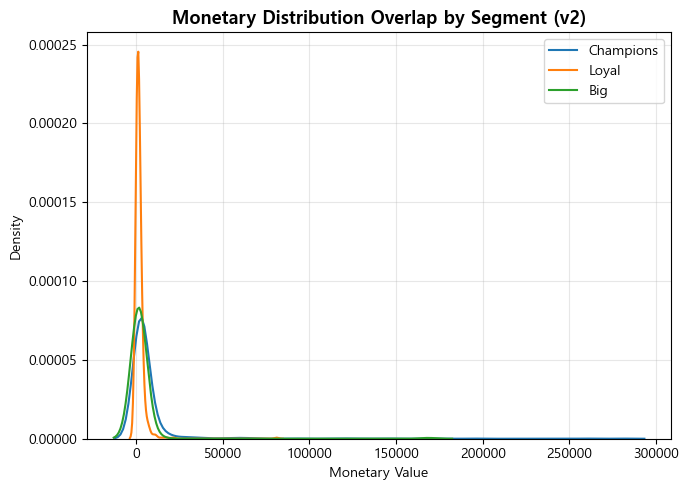

In [53]:
df_rfm_v1 = pd.read_sql("SELECT * FROM rfm_customer_segments", engine)
df_rfm_v2 = pd.read_sql("SELECT * FROM rfm_customer_segments_v2", engine)

segments_to_compare = ['Champions', 'Loyal', 'Big']

fig, ax = plt.subplots(figsize=(7, 5))

for seg in segments_to_compare:
    sns.kdeplot(
        data=df_rfm_v2[df_rfm_v2['segment_name'] == seg],
        x='monetary_value',
        ax=ax,
        label=seg,
        fill=False
    )

ax.set_title('Monetary Distribution Overlap by Segment (v2)', 
             fontsize=13, fontweight='bold')
ax.set_xlabel('Monetary Value')
ax.set_ylabel('Density')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()
